## First Step Simulation
### Model Setup
- Distribution of wages $ Y \sim Log Normal(3, 1)$
- Numbers of Observation: N=10^5
- Imposing minimum wage $m$
- Three probability parameters for workers with wage below $m$:
    1. $P_o$: probability of losing employment
    2. $P_b$: probability of bunching to wage $m$
    3. $P_s$: probability of bunching to wage $m$ plus a spillover effect that follows exponential term
        - the spillover effect shouldn't be too large.
    - In the first section, I set $P_o + P_b + P_s = 1$. In section 2 I relax the assumption by allowing workers to be unaffected by the minimum wage policy.


### Baseline Simulation Scenarios
- S1: All workers with wage below $m$ become unemployed.
    - i.e., $P_o$ = 1
- S2: All workers with wage below $m$ bunch to wage $m$
    - i.e., $P_b = 1$ 
- S3: All workers with wage below $m$ bunch to wage $m$ plus a small error term following exponential distribution.
    - i.e., $P_s=1$
- S4: Mixture of S2 and S3, with 
    - $P_b = p, \quad P_s = 1-p$

In [12]:
import os
# set wd to Users/boyuchen/Documents/UBC/RA/minimum_wage
os.chdir('/Users/boyuchen/Documents/UBC/RA/minimum_wage')
from codes.simulation_functions import *

In [2]:
#set seed
np.random.seed(2024)

Below is the baseline figure for the wage distribution in the absence of minimum wage. 5th, 10th, 15th, 20th, and 25th percentile are plotted on the left. I added lines for 5th, 15th, and 25th percentile, as well as the median and the mean. Values of median and mean are also plotted next to the line.

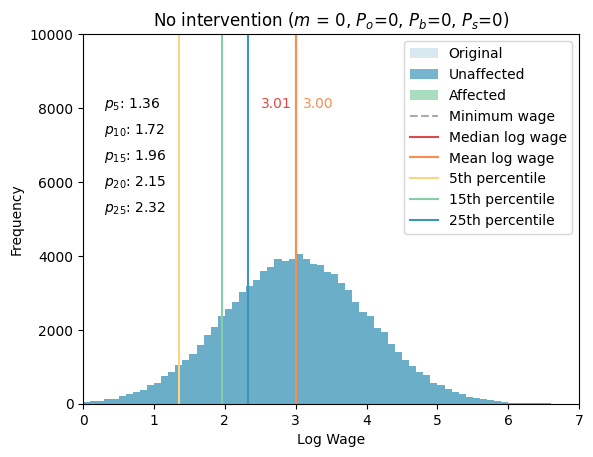

In [3]:
# Generate initial wages
N = 10**5
initial_log_wages = generate_log_wages(N)

# First plot a distribution without any intervention
df_no_intervention = pd.DataFrame({
    'original_log_wages': initial_log_wages,
    'adjusted_log_wages': initial_log_wages,
    'affected': np.zeros(N, dtype=bool)
})
# Plot the distribution without any intervention
plot_histogram_panel(plt.gca(), df_no_intervention, bins=np.arange(0, 7 + 0.1, 0.1) - 1e-6, scenario='No intervention', scenario_params=(0, 0, 0, 0), max_ylim=10_000, show_unemployed=False)


The following figures plots the wage distribution with minimum wage policy under log minimum wage of 2.2 and four probability scenarios. Faded-out histogram shows the original distribution in the absence of minimum wage policy. Bunching is extreme in S2 and S3 as no one was unemployed.

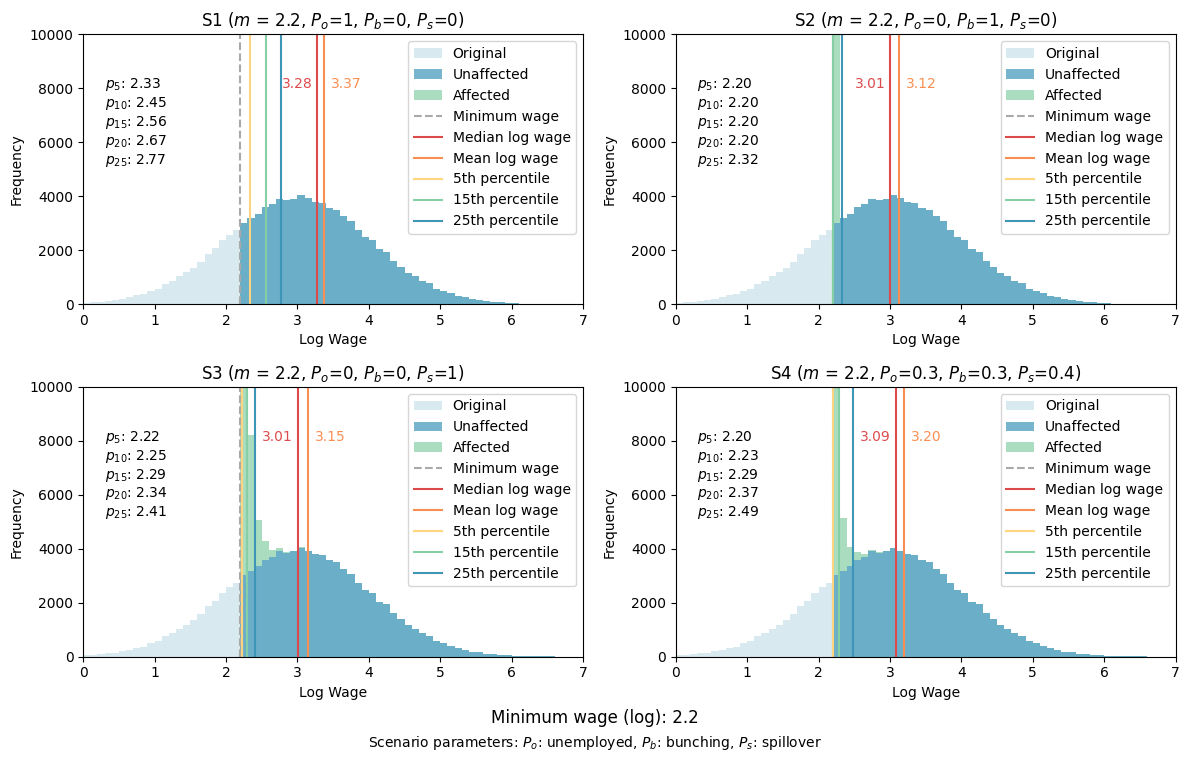

In [4]:
# Define minimum wage levels
m_new = 2.2

# Simulation generalized scenarios with lower P_b
scenarios = {
    #Scenario: (m, P_o, P_b, P_s)
    'S1': (m_new, 1, 0, 0),
    'S2': (m_new, 0, 1, 0),
    'S3': (m_new, 0, 0, 1),
    'S4': (m_new, 0.3, 0.3, 0.4)  # example with 30% bunching, 40% spillover, 30% unemployment
}

# for scenario, (m, P_o, P_b, P_s) in scenarios.items():
#     print(f"Scenario {scenario}: m={m}, (P_o={P_o}, P_b={P_b}, P_s={P_s})")
# Prepare DataFrame for each scenario

df_scenarios = {}
for scenario, (m, P_o, P_b, P_s) in scenarios.items():
    df_scenarios[scenario] = impose_minimum_wage(initial_log_wages, m, P_o, P_b, P_s)
    # assert affected wages are above minimum wage

# Determine the maximum y-limit for the plots
max_ylim = 10_000
# Plot all scenarios in one figure with multiple panels
plot_wage_distributions(df_scenarios, scenarios, max_ylim, show_unemployed=False)


### Generalized Scenario--allowing unaffected worker
In the above baseline simulation, everyone below the minimum wage are somehow affected. In the following setting, we allow some staying below the minimum wages (such as those doing informal work or report wages with measurement errors) Unemployment rates are added to the plot.

The plots below shows the simulation results, holding log minimum wage fixed at 2.2. Notice that unemployment rate is only governed by $P_o$ and $m$ and not other parameters.

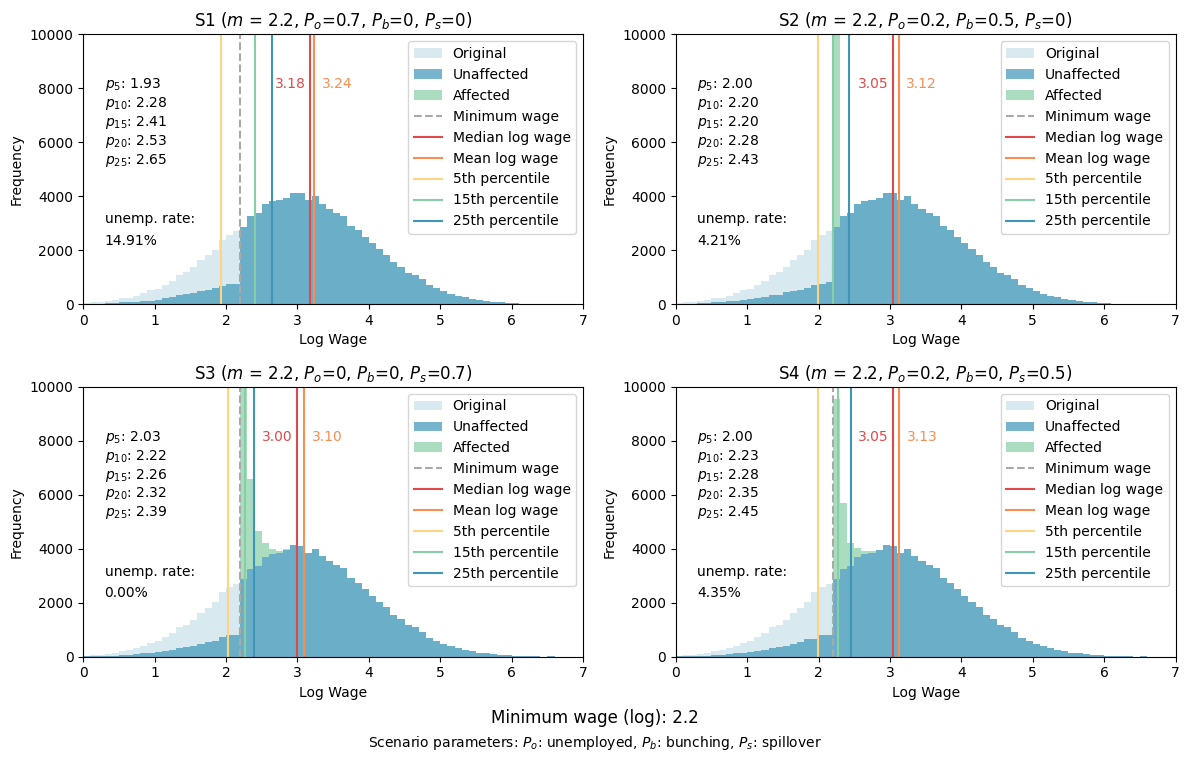

In [5]:
# Generate initial wages
N = 10**5
initial_log_wages = generate_log_wages(N)

# Define minimum wage levels
m_new = 2.2

# Simulation generalized scenarios with lower P_b
scenarios = {
    'S1': (m_new, 0.7, 0, 0),
    'S2': (m_new, 0.2, 0.5, 0),
    'S3': (m_new, 0, 0, 0.7),
    'S4': (m_new, 0.2, 0, 0.5)
}

# Prepare DataFrame for each scenario
df_scenarios = {}
for scenario, (m, P_o, P_b, P_s) in scenarios.items():
    df_scenarios[scenario] = impose_minimum_wage(initial_log_wages, m, P_o, P_b, P_s)

# Determine the maximum y-limit for the plots

# Plot all scenarios in one figure with multiple panels
plot_wage_distributions(df_scenarios, scenarios, max_ylim = 10_000, show_unemployed=True)

## Elasticity 


Before outputing the elasticity, let's show some figure of how changes in minimum wages affect the distribution. 
Probability parameters are fixed at $(P_o, P_b, P_s) =(0.2, 0, 0.5)$ in the following scenarios.

The following plots shows the distribution of log wages for different scenarios with different minimum wages with fixed probability parameters.
For example, unemployment rates are 2.28% and 5.55% when log minimum wages are 1.8 and 2.4, respectively.

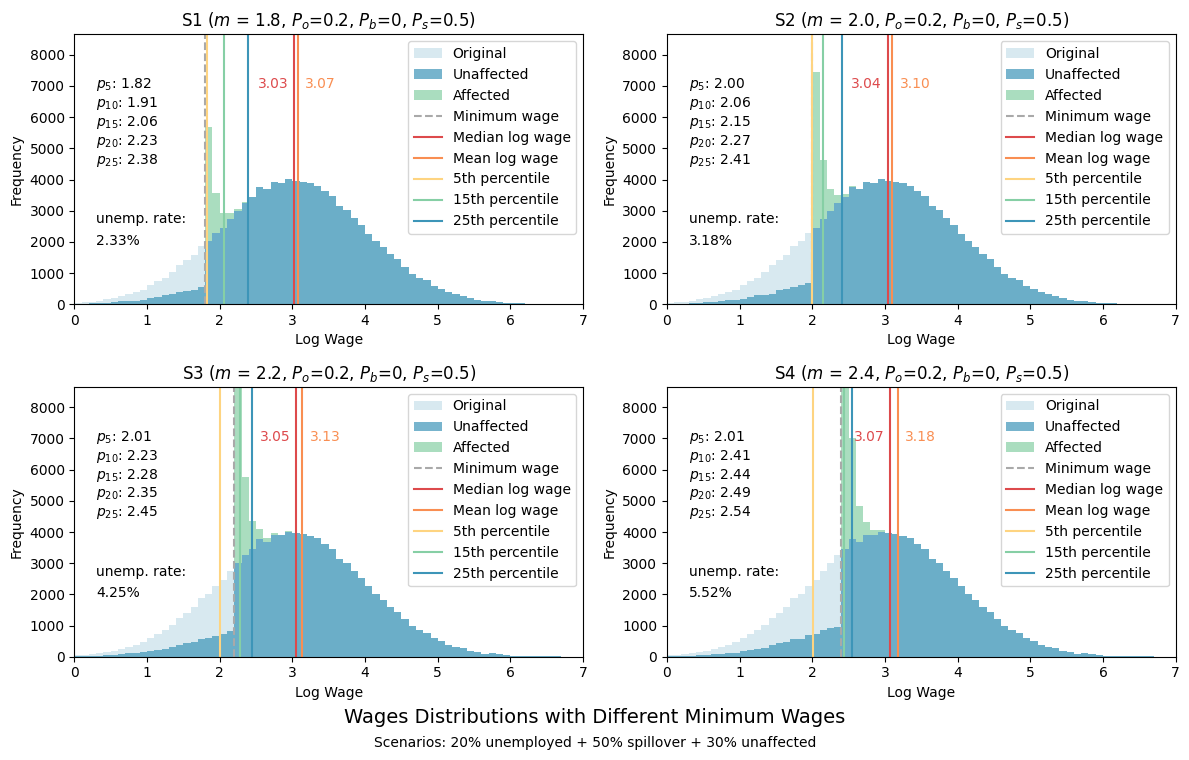

In [6]:
# Generate initial wages
N = 10**5
initial_log_wages = generate_log_wages(N)

# Define multiple minimum wage levels
min_log_wages = [1.8, 2.0, 2.2, 2.4]

# Fixed probabilities
fixed_S = [0.2, 0, 0.5]

# Simulation generalized scenarios with fixed_S for each minimum wage level
scenarios = {f'S{i+1}': (m, *fixed_S) for i, m in enumerate(min_log_wages)}

# Prepare DataFrame for each minimum wage level
df_scenarios = {}
for scenario, (m, P_o, P_b, P_s) in scenarios.items():
    df_scenarios[scenario] = impose_minimum_wage(initial_log_wages, m, P_o, P_b, P_s)

# Determine the maximum y-limit for the plots
max_ylim = 0
for df in df_scenarios.values():
    unaffected_log_wages = df['adjusted_log_wages'][~df['affected']]
    affected_log_wages = df['adjusted_log_wages'][df['affected']]
    hist_unaffected, _ = np.histogram(unaffected_log_wages[~np.isnan(unaffected_log_wages)], bins=50)
    hist_affected, _ = np.histogram(affected_log_wages[~np.isnan(affected_log_wages)], bins=50)
    max_ylim = max(max_ylim, hist_unaffected.max() + hist_affected.max())

# Plot all minimum wage levels in one figure
plot_wage_distributions_m(df_scenarios, scenarios, max_ylim, show_unemployed=True)

### Elasticity Matrix


Next we define the elasticity of employment with respect to minimum wages as follows:
$$ \epsilon = \frac{\frac{\Delta E}{E}}{\frac{\Delta m}{m}} = \frac{\frac{\Delta E}{E}}{\Delta \ln(m)}$$

where $E$ is the employment, and $m$ is the minimum wage in real scale.


- Harasztosi and Lindner (2019) reported the employment elasticities for the **directly affected workers** and I didn't see a clear definition in their paper. Is it defined to be the workers whose previous wages were below the new minimum wages? 
- Cengiz et al. (2019) estimates the employment effect on workers with previous wages under the new minimum wages, so I think it's reasonable for me to also define $E$ to be the workers that were employed wtih wages below the new minimum wages. 
- In the following simulation, I output two versions of elasticity: the local elasticity defines $E$ as described above, and the global elasticity defines $E$ to be all employment before. That is, multiplying the local elasticity with the share of *directed affected*, one can get the global elasticity.

In [8]:
#calculate elasticity matrix
# Generate initial wages
N = 10**5
initial_log_wages = generate_log_wages(N)

# Define multiple minimum wage levels
min_log_wages = [1.6, 1.8, 2.0, 2.2, 2.4]
local_elasticity_matrix = np.zeros((len(min_log_wages), len(min_log_wages)))
global_elasticity_matrix = np.zeros((len(min_log_wages), len(min_log_wages)))

for (i, m_before) in enumerate(min_log_wages):
    for (j, m_after) in enumerate(min_log_wages):
        if i < j:
            local_elasticity, global_elasticity = calculate_elasticity(initial_log_wages, m_before, m_after)
            local_elasticity_matrix[i, j] = local_elasticity
            global_elasticity_matrix[i, j] = global_elasticity
        else:
            local_elasticity_matrix[i, j] = np.nan
            global_elasticity_matrix[i, j] = np.nan
         

Text(0.5, 1.0, 'Global Elasticity of Employment')

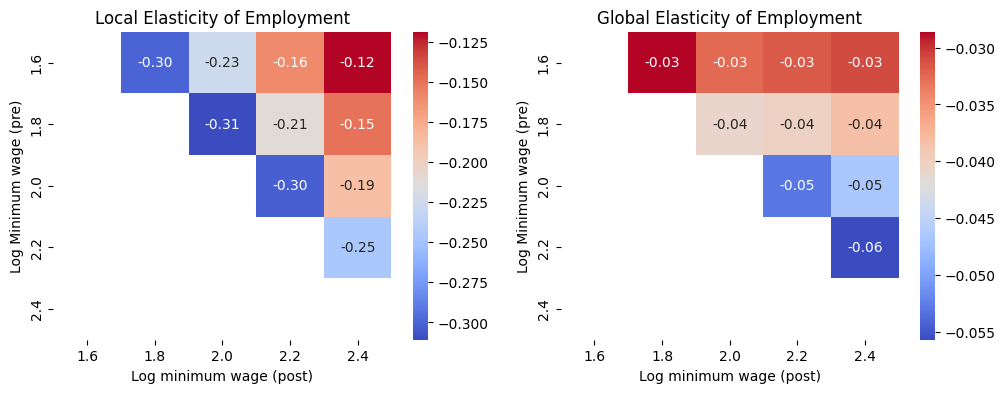

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

#local
sns.heatmap(local_elasticity_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=axs[0])
axs[0].set_xticklabels(min_log_wages)
axs[0].set_yticklabels(min_log_wages)
axs[0].set_xlabel('Log minimum wage (post)')
axs[0].set_ylabel('Log Minimum wage (pre)')
axs[0].set_title('Local Elasticity of Employment')

#global
sns.heatmap(global_elasticity_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=axs[1])
axs[1].set_xticklabels(min_log_wages)
axs[1].set_yticklabels(min_log_wages)
axs[1].set_xlabel('Log minimum wage (post)')
axs[1].set_ylabel('Log Minimum wage (pre)')
axs[1].set_title('Global Elasticity of Employment')


Harasztosi and Lindner (2019) mentioned that the (directly affected) elasticity is between -0.1 to -0.3 according to Neumark and Wascher (2010) and Brown(2019). Our local elasticities range from -0.19 to -0.37, which is quite comparable to the literature.

## Discussion and Next Steps
- I want to confirm if my local elasticity is what we want. 
- The formula you wrote for me considers th changes from no minimum wages to a minimum wage, but in most papers (and real world scenario) it's the changes between one to another higher minimum wage level. Hence I do it this way.
- Once I confirm that, I can calibrate the model to match other parameters that we want. For now, matching the employment elasticity is only related to $P_o$, but I should also calibrate $P_b$ and $P_s$ if we also want to match wage effect.
- If the model looks good, I can apply estimators on this simulated model setup. I'm checking the three papers you mentioned to understand how their estimation works in our simulation setting.
